In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
plt.rcParams['figure.figsize'] = [20, 8]

In [2]:
# from google.colab import files
# df = files.upload()
df = pd.read_csv('Platinum.csv')
df = df.reset_index()['Close']
df.head()

0    930.5
1    945.5
2    957.0
3    964.0
4    969.5
Name: Close, dtype: float64

In [3]:
# 2. Đọc file csv và gắn index
# df = pd.read_csv('../Dataset/Gold.csv')
# df = df.reset_index()['Close']
# df

In [4]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

C:\Users\admin\anaconda3\envs\py39env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, batch_size=64, verbose=1)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - loss: 0.0988 - val_loss: 0.0029
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0061 - val_loss: 0.0031
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 3

In [11]:
# 10. Dự báo dữ liệu test
y_pred = model.predict(X_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
y_pred = scaler.inverse_transform(y_pred)

In [13]:
train_size1 = int(0.6 * len(df))
test_size1 = len(df) - train_size

train_data1 = df[:train_size]
test_data1 = df[train_size:]

x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1)

In [14]:
# 12. Đánh giá độ chính xác thuật toán
# Tính MSE - Mean Squared Error - Sai số bình phương trung bình
test_mse = mean_squared_error(y_test1[time_step + 1:], y_pred)
print('Testing MSE:', test_mse)

# Tính RMSE - Root Mean Squared Error - Sai số bình phương trung bình
test_rmse = math.sqrt(test_mse)
print('Testing RMSE:', test_rmse)

# Tính MAPE - Mean Absolute Percentage Error - Tỷ lệ phần trăm sai số tuyệt đối trung bình
test_mape = mean_absolute_percentage_error(y_test1[time_step + 1:], y_pred)
print('Testing MAPE:', test_mape)

Testing MSE: 539.192396996928
Testing RMSE: 23.220516725450533
Testing MAPE: 0.019271437282085458


In [15]:
# 13. Tạo hàm dự báo
def predict(n_steps, temp_input_1, x_input_1, model, day_predict):
    lst_output = []
    temp_input = temp_input_1.copy()
    x_input = x_input_1.copy()
    i = 0

    while(i < day_predict):
        if(len(temp_input) > n_steps):
            x_input=np.array(temp_input[1:])
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i=i+1
    return lst_output

In [16]:
# Dự đoán 30, 60, 90 ngày tiếp theo
n_steps = 100
x_input = test_data[len(test_data) - n_steps:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output_30 = predict(n_steps, temp_input, x_input, model, 30)
lst_output_60 = predict(n_steps, temp_input, x_input, model, 60)
lst_output_90 = predict(n_steps, temp_input, x_input, model, 90)

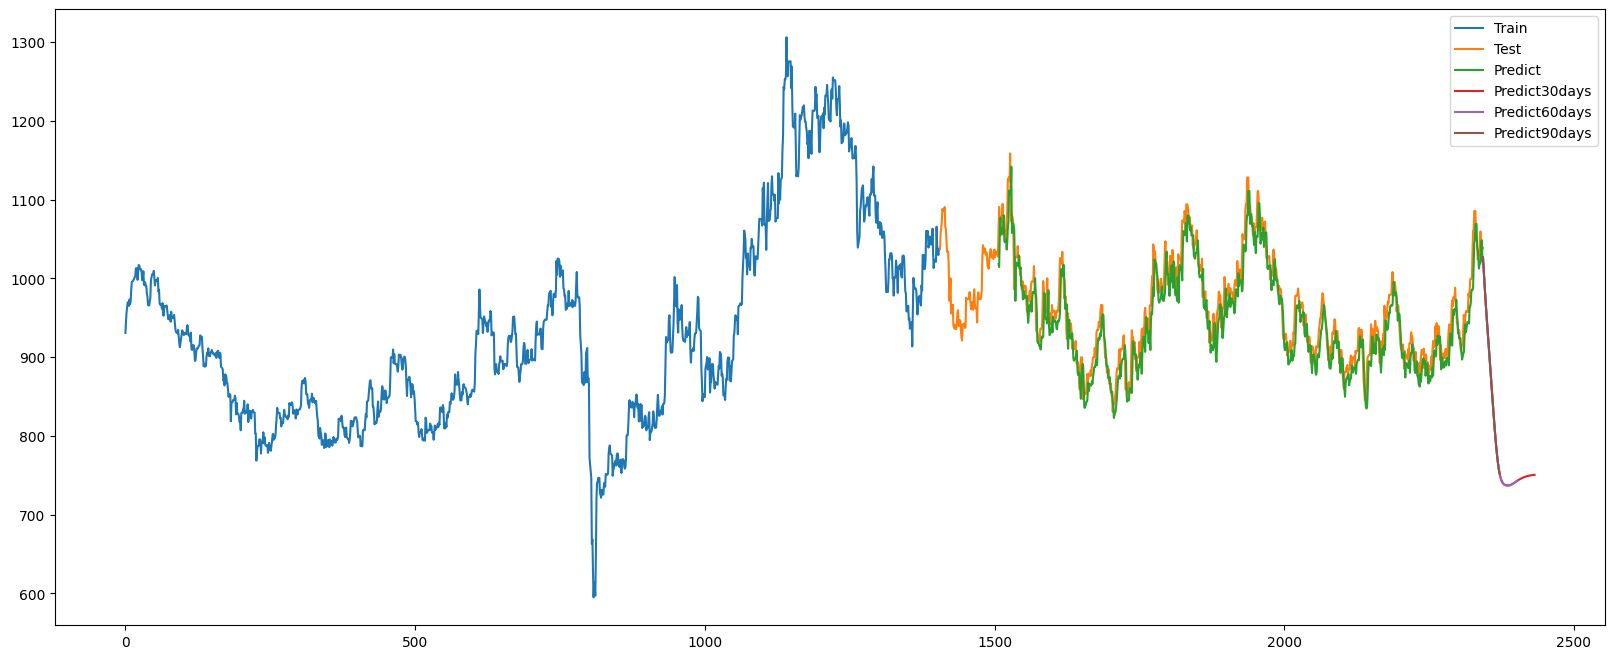

<Figure size 1600x900 with 0 Axes>

In [17]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_90))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_60))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output_30))

plt.legend(['Train','Test','Predict','Predict30days','Predict60days','Predict90days'])
plt.figure(figsize=(16,9))
plt.show()